# <center>Skill Factory Year One Final Project
## <center>Прогнозирование цен на недвижимость

## 1) Обзор проекта
Разработайте сервис для прогнозирования стоимости объектов недвижимости на основе истории предложений.

## 2) Предварительный анализ данных - Часть 1

In [1]:
# Импорт библиотек

import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from scipy import stats
from scipy.stats import shapiro
from sklearn import metrics, preprocessing
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor,
                              StackingRegressor)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor

#### Обзор данных

In [2]:
# Настроим различные пути к файлу.
W_pth = r'data.csv' # Windows path.
L_pth = '/home/mike/Documents/Coding/Data/Final project/data.csv/data.csv' # Linux path.

if os.path.exists(L_pth):
    data = pd.read_csv(L_pth)

elif os.path.exists(W_pth):
    data = pd.read_csv(W_pth)

else:
    print('Проверте верность пути нахождения файла.')

In [3]:
data.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


**Названия столбцов**
1. status
2. private pool
3. propertyType
4. street
5. baths
6. homeFacts
7. fireplace
8. city
9. schools
10. sqft
11. zipcode
12. beds
13. state
14. stories
15. mls-id
16. PrivatePool
17. MlsId
18. target

In [4]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


In [5]:
data.shape

(377185, 18)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [7]:
# Поиск дубликатов.

print('Number of full duplicates: {}'.format(data.duplicated().sum()))

Number of full duplicates: 50


In [8]:
# Удаление дубликатов.

data.drop_duplicates(inplace=True)
print('Number of lines without duplicates: {}'.format(data.shape))

Number of lines without duplicates: (377135, 18)


In [9]:
# Проверим данные на пропуски.

null_data = data.isnull().sum()
display(null_data[null_data > 0])

status           39917
private pool    372954
propertyType     34733
street               2
baths           106308
fireplace       274023
city                34
sqft             40550
beds             91254
stories         150673
mls-id          352193
PrivatePool     336825
MlsId            66869
target            2480
dtype: int64

In [10]:
# У нас есть 2480 отсутствующих значений в "target" (что составляет около 0,65% от общей базы данных).
# Они бесполезны - удалим их.

data.drop(data[data.target.isna()].index, inplace=True)
data.shape

(374655, 18)

**target**

In [11]:
data['target'] = data['target'].apply(lambda x: str(x).lower()) # Приведём все значения целевой переменной к нижнему регистру.
data['target'] = data['target'].astype(str) # Преобразуем все значения в строковый вид.
data['target'].value_counts().head() # Выведем самые частые значения.

$225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
$299,900    1276
Name: target, dtype: int64

In [12]:
# Удалим все ненужные символы.
data['target'] = data['target'].replace(r'[^\d]', '', regex=True)

# Преобразуем в числовой тип.
data['target'] = pd.to_numeric(data['target'], errors='coerce')
data['target'].value_counts().head()

225000    1806
275000    1650
250000    1644
350000    1641
325000    1562
Name: target, dtype: int64

In [13]:
# Удалим аномально малые значения цены.
data = data[data['target'] >= 1000]

In [14]:
# Тест Шапиро-Уилка на нормальность.

stat, p = shapiro(data['target'])

if p > 0.05:
    print("Целевой столбец, скорее всего, распределен нормально.")
else:
    print("Целевой столбец не распределён нормально.")

Целевой столбец не распределён нормально.


e:\ProgramData7\Anaconda3\envs\first-year\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


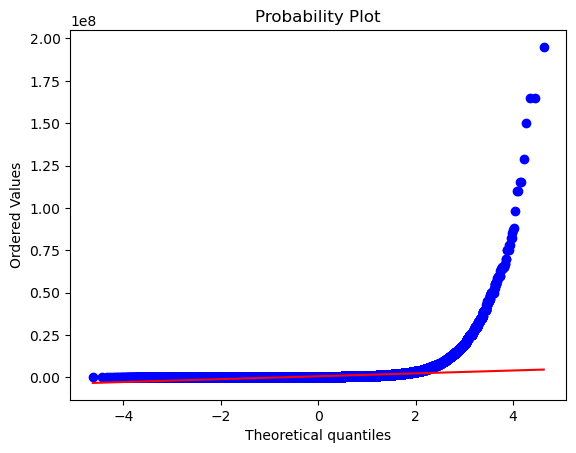

In [15]:
# Используем график Q-Q ("график квантиль-квантиль"), чтобы визуально проверить, нормально ли распределены значения в data['target'].

# Извлекаем значения из столбца 'target'.
values = data['target'].values

# Используем функцию scipy.stats.probplot для создания графика Q-Q
stats.probplot(values, dist="norm", plot=plt)

plt.show()

Целевые значения распределяются ненормально. Мы поработаем с этим позже.

Обычно на этом этапе мы создаем несколько графиков для иллюстрации и анализа данных. Однако даже числовые объекты представлены здесь в виде строк. Поэтому сначала мы проведем предварительную обработку данных, а затем рассмотрим их более подробно.

## 3) Предварительная обработка данных.

**status**

In [16]:
data['status'] = data['status'].apply(lambda x: str(x).lower())
data['status'] = data['status'].astype(str)
data['status'].describe()

count       374554
unique         150
top       for sale
freq        199511
Name: status, dtype: object

In [17]:
data['status'].value_counts(dropna=False)

for sale                   199511
active                     105187
nan                         39247
foreclosure                  5981
new construction             5458
                            ...  
coming soon: nov 8.             1
coming soon: oct 29.            1
coming soon: dec 15.            1
pending w/backup wanted         1
coming soon: dec 23.            1
Name: status, Length: 150, dtype: int64

In [18]:
# Унифицируем status.
def status_optimisation(status):
    # Создадим списки слов для поиска.
    contingent_list = ['contingent', 'contingencies', 'contingency', 'pending',
                   'continue', 'contract', 'backups', 'p', 'c', 'pi', 'ct',
                   'due diligence period', 'p pending sale', 'closed', 'pf',
                   'accepted offer', 'ps', 'backup']
    active_list = ['active', 'for sale', 'lease/purchase', 'back on market',
                   'listing extended', 're activated', 'reactivated']
    new_list = ['new', 'coming soon']
    foreclosure_list = ['foreclosure', 'pre-foreclosure']
    
    # Проверим, содержат ли строки какое-либо из слов в списках.
    if status:
        if 'rent' in status:
            return 'rent'
        elif any(word in status for word in foreclosure_list):
            return 'foreclosure'
        elif any(word in status for word in contingent_list):
            return 'contingent'
        elif any(word in status for word in active_list):
            return 'active'
        elif any(word in status for word in new_list):
            return 'new'
        else:
            return 'no data'
    else:
        return 'no data'
    
data['status'] = data['status'].apply(lambda x: status_optimisation(x))
data['status'].value_counts()

active         199539
contingent     125427
no data         39247
foreclosure      9264
new               690
rent              387
Name: status, dtype: int64

**private pool & PrivatePool**

In [19]:
data['private pool'] = data['private pool'].apply(lambda x: str(x).lower())
data['private pool'].describe()

count     374554
unique         2
top          nan
freq      370403
Name: private pool, dtype: object

In [20]:
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: str(x).lower())
data['PrivatePool'].describe()

count     374554
unique         2
top          nan
freq      334435
Name: PrivatePool, dtype: object

In [21]:
# Объединим столбцы.
data['private pool'] = data['private pool'].apply(lambda x: 1 if x == 'yes' else 0)
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 1 if x == 'yes' else 0)
data['PrivatePool'] = data['private pool'] | data['PrivatePool']
data['PrivatePool'] = data['PrivatePool'].astype('int')

**propertyType**

In [22]:
data['propertyType'] = data['propertyType'].apply(lambda x: str(x).lower())
data['propertyType'] = data['propertyType'].astype(str)
data['propertyType'].describe()

count                 374554
unique                  1272
top       single-family home
freq                   91355
Name: propertyType, dtype: object

In [23]:
data['propertyType'].value_counts(dropna=False)

single-family home                                             91355
single family                                                  61884
condo                                                          42364
nan                                                            34538
single family home                                             31724
                                                               ...  
contemporary, farmhouse                                            1
2 stories, traditional, mediterranean, texas hill country          1
1 story, contemporary, traditional, mediterranean                  1
loft, warehouse                                                    1
bilevel, converted dwelling, loft with bedrooms, condo/unit        1
Name: propertyType, Length: 1272, dtype: int64

In [24]:
# Унифицируем propertyType
def propertyType_optimisation(prop_type):
    # Создадим списки слов для поиска.
    house_list = ['house', 'family', 'home', 'traditional', 'stories', 'story', 
                  'transitional', 'florida', 'bungalow', 'cape cod', 'mediterranean']
    townhouse_list = ['townhouse', 'multiplex', 'duplex', 'triplex', 'urban', 'fourplex',
                      'attached', 'detached','split-entry']
    condo_list = ['condo', 'apartment', 'cooperative', 'high rise', 'multiple', 'coop',
                  'co-op', 'loft', 'flat', 'penthouse']
    ranches_list = ['ranches', 'rancher', 'ranch', 'farm', 'miscellaneous']
    
    # Проверим, содержат ли строки какое-либо из слов в списках.
    if prop_type:
        if any(word in prop_type for word in house_list):
            return 'house'
        elif any(word in prop_type for word in townhouse_list):
            return 'townhouse'
        elif any(word in prop_type for word in condo_list):
            return 'condo'
        elif any(word in prop_type for word in ranches_list):
            return 'ranches'
        elif 'other' in prop_type:
            return 'other'
        elif 'contemporary' in prop_type:
            return 'contemporary'
        elif 'land' in prop_type:
            return 'land'
        elif 'commercial' in prop_type:
            return 'other'
        elif 'mobile' in prop_type:
            return 'mobile'
        elif 'nan' in prop_type:
            return 'no data'
        else:
            return 'house'
    else:
        return 'no data'
    
data['propertyType'] = data['propertyType'].apply(lambda x: propertyType_optimisation(x))
data['propertyType'].value_counts()

house           248691
condo            49504
no data          34538
land             31404
contemporary      2760
mobile            2670
ranches           2422
townhouse         1911
other              654
Name: propertyType, dtype: int64

**street**

In [25]:
data['street'] = data['street'].apply(lambda x: str(x).lower())
data['street'].describe()

count                    374554
unique                   333851
top       address not disclosed
freq                        672
Name: street, dtype: object

In [26]:
data['street'].value_counts().head(10)

address not disclosed    672
undisclosed address      515
(undisclosed address)    391
address not available    175
unknown address           72
2103 e state hwy 21       57
11305 gulf fwy            54
17030 youngblood rd.      38
ne 58th cir               34
9470 lancaster rd. sw     32
Name: street, dtype: int64

In [27]:
# Унифицируем street.
def street_optimisation(address):
    # Создадим списки слов для поиска.
    drive_list = ['drive', 'dr', 'edr', 'ndr', 'sdr', 'wdr']
    lane_list = ['lane', 'ln', 'eln', 'nln', 'sln', 'wln', 'laneway', 'lnwy']
    way_list = ['way', 'freeway', 'fwy', 'highway', 'hwy', 'driveway', 'dvwy', 
                'expressway', 'exp', 'fairway', 'fawy', 'footway', 'ftwy',
                'motorway', 'mtwy', 'parkway', 'pkwy', 'pwy', 'pathway', 'pway']
    
    # Проверим, содержат ли строки какое-либо из слов в списках.
    if address:
        if 'address' in address: return 'no data'
        elif 'street' in address: return 'street'
        elif 'st' in address: return 'street'
        elif any(word in address for word in drive_list):
            return 'drive'
        elif any(word in address for word in lane_list):
            return 'lane'
        elif any(word in address for word in way_list):
            return 'way'
        elif 'avenue' in address: return 'avenue'
        elif 'ave' in address: return 'avenue'
        elif 'rd' in address: return 'road'
        elif 'road' in address: return 'road'
        elif 'blvd' in address: return 'blvd'
        elif 'circle' in address: return 'circle'
        elif 'cir' in address: return 'circle'
        elif 'ct' in address: return 'court'
        elif 'court' in address: return 'court'
        elif 'pl' in address: return 'place'
        elif 'place' in address: return 'place'
        else:
            return 'other'
    else:
        return 'no data'

data['street'] = data['street'].apply(lambda x: street_optimisation(x))
data['street'].value_counts().head(50)

street     109836
drive       59737
avenue      58525
road        33303
other       27129
lane        21636
court       15401
place       14757
way         13208
blvd        11827
circle       7362
no data      1833
Name: street, dtype: int64

**baths**

In [28]:
data['baths'] = data['baths'].apply(lambda x: str(x).lower())
data['baths'].describe()

count     374554
unique       225
top          nan
freq      105275
Name: baths, dtype: object

In [29]:
data['baths'].value_counts().head(10)

nan             105275
2 baths          52063
3 baths          35392
2                20428
2.0              16354
4 baths          14723
3.0              10795
3                10093
bathrooms: 2      9410
2.5               8113
Name: baths, dtype: int64

In [30]:
# Удалим запятые для больших чисел (например, 1,000 или 1,750).
# Строки с большими значениями не являются ванными комнатами. Мы удалим их позже.
data['baths'] = data['baths'].str.replace(',', '', regex=True)
# Округлим такие значения, как "2,5 ванные комнаты".
data['baths'] = data['baths'].str.replace('\.\d+', '', regex=True)
# Оставим только цифры.
data['baths'] = data['baths'].str.replace('\D+', '', regex=True)

In [31]:
data['baths']=pd.to_numeric(data['baths'], errors='coerce')
# Отсутствует много данных. Мы берем на себя риск заполнить его цифрой "2".
data['baths'] = data['baths'].fillna('2')
data['baths'] = data['baths'].astype('int')

In [32]:
# Заменим значения более 50 ванных комнат на 2.
data['baths'] = data['baths'].apply(lambda x: 2 if x > 50 else x)
# Заменим значения всех 9+ ванных комнат на 9
data['baths'] = data['baths'].apply(lambda x: 9 if x > 9 else x)
data['baths'] = data['baths'].astype('int16')
data['baths'].value_counts().head(10)

2    235261
3     70257
4     27515
1     18491
5      9733
6      4486
0      3918
7      2140
9      1564
8      1189
Name: baths, dtype: int64

**homeFacts**

In [33]:
data['homeFacts'] = data['homeFacts'].apply(lambda x: str(x).lower())
data['homeFacts'].describe()

count                                                374554
unique                                               318345
top       {'ataglancefacts': [{'factvalue': '', 'factlab...
freq                                                   7134
Name: homeFacts, dtype: object

In [34]:
# Структура этой ячейки немного сложна.
data['homeFacts'][0]

"{'ataglancefacts': [{'factvalue': '2019', 'factlabel': 'year built'}, {'factvalue': '', 'factlabel': 'remodeled year'}, {'factvalue': 'central a/c, heat pump', 'factlabel': 'heating'}, {'factvalue': '', 'factlabel': 'cooling'}, {'factvalue': '', 'factlabel': 'parking'}, {'factvalue': none, 'factlabel': 'lotsize'}, {'factvalue': '$144', 'factlabel': 'price/sqft'}]}"

In [35]:
# Разберемся с "lot_size". Некоторые из них написаны в акрах.
# Создадим новый столбец 'lotsize_measure', чтобы отметить те ячейки, в которых используются акры.

import re

def get_lotsize_measure(home_facts_str):
    if re.search(r"acre['s]*", home_facts_str):
        return 'acre'
    return None

data['lotsize_measure'] = data['homeFacts'].apply(get_lotsize_measure)
data['lotsize_measure'].value_counts()

acre    76827
Name: lotsize_measure, dtype: int64

In [36]:
# Удалим все нечисловые символы, используемые в "factvalue".

import re

def process_home_facts(home_facts):
    # Перейдём в нижний регистр.
    home_facts = home_facts.lower()
    # Удалим запятые между цифрами.
    home_facts = re.sub(r'(\d),(\d)', r'\1\2', home_facts)
    # Удалим символ '$'.
    home_facts = home_facts.replace('$', '')
    # Удалим строки ' sqft', '/sqft', и ' sq. ft.'.
    home_facts = home_facts.replace(' sqft', '')
    home_facts = home_facts.replace('/sqft', '')
    home_facts = home_facts.replace(' sq. ft.', '')
    # Удалим строки ' lot', ' acres', ' acre', и 'contact manager'.
    home_facts = home_facts.replace(' lot', '')
    home_facts = home_facts.replace(' acres', '')
    home_facts = home_facts.replace(' acre', '')
    home_facts = home_facts.replace('contact manager', '')
    # Удалим '—', '-', ' /' и 'no info'.
    home_facts = home_facts.replace('—', '')
    home_facts = home_facts.replace('-', '')
    home_facts = home_facts.replace(' /', '')
    home_facts = home_facts.replace('no info', '')
    return home_facts

# Выполним итерацию по каждой строке в столбце "homeFacts".
for i, row in data.iterrows():
    home_facts = row['homeFacts']
    home_facts = process_home_facts(home_facts)
    data.at[i, 'homeFacts'] = home_facts

In [ ]:
# Создим шаблон регулярного выражения для сопоставления пары ключ-значение в строке
pattern = r"{'factvalue': '(.*?)', 'factlabel': '(.*?)'}"

# Выполним итерацию по каждой строке в столбце "homeFacts".
for i, row in data.iterrows():
    home_facts_str = row['homeFacts']

    # Найдём все пары ключ-значение в строке.
    matches = re.finditer(pattern, home_facts_str)
    home_facts = {}
    for match in matches:
        factvalue = match.group(1)
        factlabel = match.group(2)
        home_facts[factlabel] = factvalue

    # Обновим строку извлеченными парами ключ-значение, преобразовав в соответствующий тип данных 
    # 'year_built' и 'remodeled year' - int
    year_built = home_facts.get('year built', None)
    if year_built is None or year_built == 'no data' or year_built == '':
        data.at[i, 'year built'] = None
    else:
        data.at[i, 'year built'] = int(year_built)
    
    remodeled_year = home_facts.get('remodeled year', None)
    if remodeled_year is None or remodeled_year == 'no data' or remodeled_year == '':
        data.at[i, 'remodeled year'] = None
    else:
        data.at[i, 'remodeled year'] = int(remodeled_year)

    # 'heating', 'cooling', 'parking' - str
    data.at[i, 'heating'] = home_facts.get('heating', None)
    data.at[i, 'cooling'] = home_facts.get('cooling', None)
    data.at[i, 'parking'] = home_facts.get('parking', None)

    # 'lotsize', ' price' - float
    lot_size = home_facts.get('lotsize', None)
    if lot_size is None or lot_size == 'no data' or lot_size == '':
        data.at[i, 'lotsize'] = None
    else:
        data.at[i, 'lotsize'] = float(lot_size)

    price_sqft = home_facts.get('price', None)
    if price_sqft is None or price_sqft == 'no data' or price_sqft == '':
        data.at[i, 'price'] = None
    else:
        data.at[i, 'price'] = float(price_sqft)